# A/B–тестирование
В необозначенный момент времени пользователи образовательной онлайн-платформы Х были случайным образом распределены либо в контрольную группу A, либо в целевую группу B. В течение также неназванного периода наблюдения при оформлении покупки на сайте пользователям из группы A предлагалось воспользоваться базовой механикой оплаты, а членам группы B — обновлённой. Все релевантные взаимодействия участников эксперимента с сайтом были записаны в .csv-таблицы. 

Ноутбук посвящен анализу этого набора данных ([источник](https://karpov.courses/analytics)) с целью оценки целесообразности развертывания новой механики оплаты на всех нынешних и будущих пользователей платформы.

## Описание данных
### groups.csv - таблица с информацией о принадлежности пользователей к контрольной (А) или целевой (В) группе.
* *id* - уникальный идентификатор пользователя в системе.
* *grp* - группа, к которой принадлежит пользователь.
### groups_add.csv - дополнительная таблица с информацией о принадлежности пользователей к группе А или В.
* *id* - уникальный идентификатор пользователя в системе.
* *grp* - группа, к которой принадлежит пользователь.
### active_studs.csv - список пользователей, воспользовавшихся платформой в период сбора данных.
* *student_id* - то же, что *id*.
### checks.csv - таблица с информацией о размере денежных средств, потраченных пользователями платформы в период сбора данных. 
* *student_id* - то же, что *id*.
* *rev* - сколько денег было потрачено пользователем.

## Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import requests
import seaborn as sns
from scipy import stats

## Чтение и обзор данных
Выгрузим данные с Яндекс Диска, воспользовавшись API для получения прямой ссылки на скачивание.

In [2]:
# API URL
api_url = r'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Публичные URL файлов
groups_url = r'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = r'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = r'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = r'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
def read_csv(public_url,
             api_url=r'https://cloud-api.yandex.net/v1/disk/public/resources/download?',
             delimiter=','):
    """
    Считывает данные из CSV файла, сохраненного в облачном хранилище,
    в объект DataFrame библиотеки pandas.
    
    Параметры:
    
    public_url (str): публичный URL CSV файла.
    
    api_url (str): URL-адрес API облачного сервиса; по умолчанию используется
    адрес API Яндекс Диска.
    
    delimiter (str): разделитель, используемый при считывании CSV файлов;
    ',' - значение по умолчанию.

    Возвращает:
    pandas.DataFrame, содержащий данные из CSV файла.
    """
    response = requests.get(api_url, params={'public_key': public_url})
    # Проверка входных URL.
    if response.status_code != 200:
        print("Something's wrong. Check the public and/or API URL!")
        exit()
    return pd.read_csv(response.json()['href'], delimiter=delimiter)

#### groups

In [4]:
groups = read_csv(groups_url, delimiter=';')
# Выведем первые 5 строк получившегося DataFrame.
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Переименуем колонку *grp* в *group*; выведем базовую информацию о таблице.

In [5]:
groups.rename(columns={"grp": "group"}, inplace=True)
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   group   74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Видим, что в **groups** отсутствуют пропущенные значения.

#### groups_add

In [6]:
groups_add = read_csv(groups_add_url)
# Выведем первые 5 строк получившегося DataFrame.
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


Переименуем колонку *grp* в *group*; выведем базовую информацию о таблице.

In [7]:
groups_add.rename(columns={"grp": "group"}, inplace=True)
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   group   92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


Видим, что в **groups_add** также нет пропущенных значений.

#### active_studs

In [8]:
active_studs = read_csv(active_studs_url)
# Выведем первые 5 строк получившегося DataFrame
# (пусть у него и всего одна колонка, это DataFrame).
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Переименуем колонку *student_id* в *id*; выведем базовую информацию о таблице.

In [9]:
active_studs.rename(columns={"student_id": "id"}, inplace=True)
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


Есть ли в таблице повторяющиеся значения?

In [10]:
active_studs.nunique()

id    8341
dtype: int64

Каждый *id* в таблице **active_studs** уникален. Это означает, что если пользователь заходил на платформу более одного раза, то записи-дубликаты не создавались. 

#### checks

In [11]:
checks = read_csv(checks_url, delimiter=';')
# Выведем первые 5 строк получившегося DataFrame.
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Переименуем колонку *student_id* в *id*, колонку *rev* в *revenue*; выведем базовые сведения о таблице.

In [12]:
checks.rename(columns={"student_id": "id", "rev": "revenue"}, inplace=True)
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       541 non-null    int64  
 1   revenue  541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Есть ли в таблице повторяющиеся идентификаторы пользователей?

In [13]:
checks['id'].nunique()

541

Каждый *id* в таблице уникален: либо пользователи совершали всего 1 покупку, либо таблица содержит их суммарные траты за весь период накопления данных.

In [14]:
541 / 8341

0.06486032849778205

Обратим внимание, что из 8341 активного пользователя лишь 541 совершили покупки - это около 6,5%.

## Работа с данными
Прежде всего рассмотрим основной набор данных – то есть таблицы **groups**, **active_studs** и **checks**. После выбора и расчета метрик для оценки нового механизма оплаты, оформим все выполняемые над исходными данными манипуляции в виде функций. Затем создадим функцию для автоматического учета информации из дополнительного файла **groups_add.csv**.
### Первичные обработка и анализ
Определим, какие пользователи из **groups** проявляли активность в период наблюдения. Для этого объединим эту таблицу с **active_studs**, предварительно создав в последней столбец-маркер.

In [15]:
active_studs['active'] = 1
active_studs.head()

,id,active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [16]:
df = pd.merge(left=groups, right=active_studs, how='left', on='id') \
    .fillna(value=0)  # неактивные юзеры будут обозначены нулем в колонке active
df.head()

,id,group,active
0,1489,B,0.0
1,1627,A,1.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


Добавим в **df** информацию о платежах, совершенных пользователями в течение периода наблюдения, из таблицы **checks**.

In [17]:
df = pd.merge(left=df, right=checks, how='left', on='id') \
    .fillna(value=0)  # юзеры без оплат будут обозначены нулем в колонке revenue
df.head()

,id,group,active,revenue
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


Каков размер контрольной (А) и целевой (В) групп?

In [18]:
tmp = df.groupby(by='group').agg({'id':'count'})
tmp

,id
group,
A,14671
B,59813


In [19]:
tmp.loc['B'] / tmp.loc['A']

id    4.076955
dtype: float64

Размер целевой выборки в четыре раза превышает размер контрольной. Такой дизайн эксперимента не является оптимальным, поскольку столь большие различия в размере выборок негативно влияют на надежность оценок, получаемых с помощью целого ряда статистических тестов. Например, даже если значения в рассматриваемых выборках имеют распределение, близкое к нормальному, и их дисперсии приблизительно равны, вместо стандартного t-теста для сравнения средних настолько несбалансированных данных следует применять t-тест Уэлча.

Если ли пользователи, которые совершили покупку, но не зашли на платформу?

In [20]:
print("Number of paying but inactive users is",
      f"{df.query('revenue != 0 and active == 0').shape[0]}")

Number of paying but inactive users is 149


Действительно, такие пользователи есть. Можно предположить, что они ранее, до начала сбора данных, оформили подписку на некоторую услугу, предоставляемую платформой, и произошло её автоматическое продление.

Поскольку исследуется влияние новой механики оплаты услуг на сайте на "вероятность" совершения покупки, пользователи, которые не посещали сайт за время наблюдения, не представляют для нас интереса и исключаются из дальнейших вычислений.

In [21]:
df = df.query('active == 1')
# небольшая проверка
print("Number of paying but inactive users is",
      f"{df.query('revenue != 0 and active == 0').shape[0]}")

Number of paying but inactive users is 0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8328 entries, 1 to 74469
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       8328 non-null   int64  
 1   group    8328 non-null   object 
 2   active   8328 non-null   float64
 3   revenue  8328 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 325.3+ KB


Как изменился размер групп после фильтрации?

In [23]:
tmp = df.groupby(by='group').agg({'id':'count'})
tmp

,id
group,
A,1535
B,6793


In [24]:
tmp.loc['B'] / tmp.loc['A']

id    4.425407
dtype: float64

После фильтрации соотношение целевой выборки к контрольной увеличилось до ~4.42, что делает проведенный эксперимент методологически ещё менее корректным.

Удалим из **df** столбец *active*; добавим столбец *made_purchase*, который будет содержать два значения: 0 (пользователь ничего не покупал) и 1 (пользователь совершал покупку). 

In [25]:
df.drop(columns='active', inplace=True)
df['made_purchase'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,id,group,revenue,made_purchase
1,1627,A,990.0,1
10,2085,B,0.0,0
12,2215,B,0.0,0
43,3391,A,0.0,0
45,3401,B,0.0,0


### Выбор и расчёт метрик
Представляется разумным рассмотреть **конверсию в покупку (CR)** в качестве главного показателя успеха / неудачи новой механики оплаты услуг на сайте. Так, если новая механика "лучше" старой, то большее число пользователей должно совершать целевое действие, т.е. покупку, и наоборот. 

В дополнение к **CR** рассчитаем и проанализируем показатели **среднего дохода с привлеченного пользователя (ARPU)** и **среднего дохода с платящего пользователя (ARPPU)**. Эти метрики, которые в данном случае имеют вспомогательный, справочный характер, применяются исходя из предположения о том, что при наличии более удобной системы оплаты пользователи будут чаще совершать покупки и тратить больше денег, что, в свою очередь, приведет к увеличению **ARPU** и **ARPPU**.

Сгруппируем данные из **df** в новую таблицу **summary_table**, в строки которой внесём такую информацию о группах А и В, как: количество пользователей, количество пользователей, совершивших покупку, и общая прибыль.

In [26]:
summary_table = df.groupby(by='group') \
    .agg({'id':'count', 'made_purchase': 'sum', 'revenue': 'sum'}) \
    .rename(columns={'id': 'users_total', 'made_purchase': 'users_purchase',
                     'revenue': 'revenue_total'})
summary_table

,users_total,users_purchase,revenue_total
group,,,
A,1535,78,72820.0000
B,6793,313,393074.0035


Используя **summary_table**, рассчитаем метрики **CR**, **ARPU** и **ARPPU**:
* CR = число пользователей, совершивших покупку / общее число пользователей;
* ARPU = сумма всех трат пользователей / общее число пользователей;
* ARPPU = сумма всех трат пользователей / число пользователей, совершивших покупку.

In [27]:
metrics = pd.DataFrame()
# Запишем CR в %
metrics['CR'] = 100*(summary_table['users_purchase'] / summary_table['users_total'])
metrics['ARPU'] = (summary_table['revenue_total'] / summary_table['users_total']) 
metrics['ARPPU'] = (summary_table['revenue_total'] / summary_table['users_purchase']) 
metrics.round(3)

,CR,ARPU,ARPPU
group,,,
A,5.081,47.440,933.590
B,4.608,57.865,1255.827


Из таблицы видно, что показатель **CR** группы В, пользователи из которой взаимодействовали с новым механизмом, ниже, чем у контрольной группы А, а **ARPU** и **ARPPU** выше.

Прежде чем приступить к оценке стат. значимости этих различий, напишем функции для выполнения описанных выше операций с данными, а также для учета дополнительных файлов вида **groups_add.csv**. 

### Рефакторинг и учёт дополнительных данных 
Удалим избыточные объекты

In [28]:
try:
    del (groups, groups_add, active_studs, checks, summary_table, metrics, tmp)
except Exception as e:
    print(e, type(e))

Сохраним URL файлов и API облачного хранилища в переменные.

In [29]:
# API URL
api_url = r'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Публичные URL файлов
groups_url = r'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = r'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = r'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = r'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

Определение функций.

In [30]:
def read_csv(public_url,
             api_url=r'https://cloud-api.yandex.net/v1/disk/public/resources/download?',
             delimiter=','):
    """
    Считывает данные из CSV файла, сохраненного в облачном хранилище,
    в объект DataFrame библиотеки pandas.
    
    Параметры:
    public_url (str): Публичный URL-адрес CSV файла.
    
    api_url (str): URL-адрес API облачного сервиса; по умолчанию используется
    адрес API Яндекс Диска.
    
    delimiter (str): разделитель, используемый при считывании CSV файлов;
    ',' - значение по умолчанию.

    Возвращает:
    pandas.DataFrame, содержащий данные из CSV файла.
    """
    response = requests.get(api_url, params={'public_key': public_url})
    # Проверка входных URL.
    if response.status_code != 200:
        print("Something's wrong. Check the public and/or API URL!")
        exit()
    return pd.read_csv(response.json()['href'], delimiter=delimiter)

In [31]:
def prepare_data(public_urls, api_url='', delimiters=[",", ",", ","]):
    """
    Считывает из облачного хранилища CSV-таблицы active_studs, checks
    и groups (groups_add) в объекты pandas.DataFrame, а затем формирует на их основе 
    новый DataFrame, предназначенный для последующего расчета метрик CR, ARPU
    и ARPPU.

    Параметры:
    public_urls (list): список публичных URL-адресов CSV файлов.
    Первый элемент списка должен соответствовать таблице active_studs,
    второй - checks, третий - groups.
    
    api_url (str): URL-адрес API облачного хранилища; по умолчанию используется
    адрес API Яндекс Диска.
    
    delimiters (list): список разделителей, используемых при считывании CSV файлов.
    Первый элемент списка задаёт разделитель для active_studs, второй - checks,
    третий - groups (groups_add). По умолчанию для всех трех случаев
    используется ','.

    Возвращает:
    df (pandas.DataFrame): таблица со следующими столбцами:
    - id: уникальный идентификатор пользователя;
    - group: группа, к которой отнесен пользователь (А или В);
    - revenue: сумма денежных средств, потраченных пользователем;
    - made_purchase: флаг совершения покупки (1 - покупка совершена,
    0 - покупка не совершена).
    """
    if len(public_urls) != 3:
        raise ValueError("Need to pass 3 public URLs")

    if api_url:  # В api_url было что-то передано.
        # Чтение active_studs.
        active_studs = read_csv(public_urls[0], api_url, delimiter=delimiters[0])
        active_studs.rename(columns={"student_id": "id"}, inplace=True)
        # Чтение checks.
        checks = read_csv(public_urls[1], api_url, delimiter=delimiters[1])
        checks.rename(columns={"student_id": "id",
                      "rev": "revenue"}, inplace=True)
        # Чтение groups.
        groups = read_csv(public_urls[2], api_url, delimiter=delimiters[2])
        groups.rename(columns={"grp": "group"}, inplace=True)
    else:  # Используется значение api_url по умолчанию.
        # Чтение active_studs.
        active_studs = read_csv(public_urls[0], delimiter=delimiters[0])
        active_studs.rename(columns={"student_id": "id"}, inplace=True)
        # Чтение checks.
        checks = read_csv(public_urls[1], delimiter=delimiters[1])
        checks.rename(columns={"student_id": "id",
                      "rev": "revenue"}, inplace=True)
        # Чтение groups.
        groups = read_csv(public_urls[2], delimiter=delimiters[2])
        groups.rename(columns={"grp": "group"}, inplace=True)

    # Поскольку при расчете метрик интерес представляют только активные
    # пользователи, первый pd.merge выполняется с ключом inner (пересечение по id).
    df = pd.merge(left=groups, right=active_studs, how="inner", on="id")
    # Отсутствующие значения заменяем нулями.
    df = pd.merge(left=df, right=checks, how="left", on="id") \
        .fillna(value=0)

    # Добавим столбец со значениями:
    # 0, если пользователь ничего не покупал,
    # 1, если пользователь совершал покупку.
    df["made_purchase"] = df["revenue"].apply(lambda x: 1 if x > 0 else 0)

    return df

In [32]:
def process_data(df):
    """
    На основе pandas.DataFrame, полученного при помощи функции prepare_data,
    создает два новых объекта DataFrame: summary и metrics.
    
    Параметры:
    df (pandas.DataFrame): таблица со следующими столбцами:
    - id: уникальный идентификатор пользователя;
    - group: группа, к которой отнесен пользователь (А или В);
    - revenue: сумма денежных средств, потраченных пользователем;
    - made_purchase: флаг совершения покупки (1 - покупка совершена,
    0 - покупка не совершена).
    
    Возвращает:
    summary (pandas.DataFrame): таблица, содержащая следующую информацию
    о группах А и В:
    - users_total: общее число пользователей;
    - users_purchase: количество пользователей, совершивших покупку;
    - revenue_total: сумма всех потраченных пользователями денег.
    
    metrics (pandas.DataFrame): таблица с рассчитанными для групп A и B метриками:
    - CR в %: 100 * (число пользователей, совершивших покупку /
    общее число пользователей);
    - ARPU: сумма всех трат пользователей / общее число пользователей;
    - ARPPU: сумма всех трат пользователей / число пользователей,
    совершивших покупку.
    """
    # Расчет сводной таблицы.
    summary = df.groupby(by='group') \
        .agg({'id':'count', 'made_purchase': 'sum', 'revenue': 'sum'}) \
        .rename(columns={'id': 'users_total', 'made_purchase': 'users_purchase',
                         'revenue': 'revenue_total'})
    # summary = summary.round(3)

    # Расчет метрик, их сохранение в таблице.
    metrics = pd.DataFrame()
    metrics['CR'] = 100 * (summary['users_purchase'] / summary['users_total'])
    metrics['ARPU'] = (summary['revenue_total'] / summary['users_total']) 
    metrics['ARPPU'] = (summary['revenue_total'] / summary['users_purchase']) 
    # metrics = metrics.round(3)

    return summary, metrics 

In [33]:
def combine_data(df1, public_urls, api_url='', delimiters=[",", ",", ","]):
    """
    Считывает из облачного хранилища CSV-таблицы active_studs, checks
    и groups_add в объекты pandas.DataFrame, а затем объединяет их в новый
    DataFrame df2. Далее df2 конкатенируется к df1, и на основе результирующей
    таблицы создаются обновленные summary и metrics.

    Параметры:
    df1 (pandas.DataFrame): таблица со следующими столбцами:
    - id: уникальный идентификатор пользователя;
    - group: группа, к которой отнесен пользователь (А или В);
    - revenue: сумма денежных средств, потраченных пользователем;
    - made_purchase: флаг совершения покупки (1 - покупка совершена,
    0 - покупка не совершена).
    
    public_urls (list): список публичных URL-адресов CSV файлов.
    Первый элемент списка должен соответствовать таблице active_studs,
    второй - checks, третий - groups_add.
    
    api_url (str): URL-адрес API облачного хранилища; по умолчанию используется
    адрес API Яндекс Диска.
    
    delimiters (list): список разделителей, используемых при считывании CSV файлов.
    Первый элемент списка задаёт разделитель для active_studs, второй - checks,
    третий - groups_add. По умолчанию для всех трех случаев используется ','.

    Возвращает:
    df3 (pandas.DataFrame) - таблица, аналогичная по структуре df1, но включающая
    в себя данные не только из groups.csv, но и groups_add.csv.
    
    df3_summary (pandas.DataFrame): таблица, содержащая следующую информацию
    об обновленных группах А и В:
    - users_total: общее число пользователей;
    - users_purchase: количество пользователей, совершивших покупку;
    - revenue_total: сумма всех потраченных пользователями денег.
    
    df3_metrics (pandas.DataFrame): таблица с рассчитанными для обновленных групп
    A и B метриками:
    - CR в %: 100 * (число пользователей, совершивших покупку /
    общее число пользователей);
    - ARPU: сумма всех трат пользователей / общее число пользователей;
    - ARPPU: сумма всех трат пользователей / число пользователей,
    совершивших покупку.
    """
    
    # Подготовка новых данных...
    df2 = prepare_data(public_urls, api_url, delimiters)
    # ...и их конкатенация к уже имеющимся.
    df3 = pd.concat([df1, df2])

    # Проверка на повторяющиеся ID пользователей
    if not df3[df3['id'].duplicated()].empty:
        print('There are duplicated IDs in the data!')

    # Построение сводной таблицы и таблицы метрик.
    df3_summary, df3_metrics = process_data(df3)
    
    return df3, df3_summary, df3_metrics

Применим функции для обработки основного набора данных - т.е, файлов **groups.csv**, **active_studs.csv** и **checks.csv**.

In [34]:
df = prepare_data(public_urls=[active_studs_url, checks_url, groups_url],
                   delimiters=[',', ';', ';'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8328 entries, 0 to 8327
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8328 non-null   int64  
 1   group          8328 non-null   object 
 2   revenue        8328 non-null   float64
 3   made_purchase  8328 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 260.4+ KB


In [35]:
df.head()

,id,group,revenue,made_purchase
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


Все ли id в таблице **df** уникальны?

In [36]:
df.id.nunique()

8328

In [37]:
df_summary, df_metrics = process_data(df)

In [38]:
df_summary.round(3)

,users_total,users_purchase,revenue_total
group,,,
A,1535,78,72820.000
B,6793,313,393074.004


In [39]:
df_metrics.round(3)

,CR,ARPU,ARPPU
group,,,
A,5.081,47.440,933.590
B,4.608,57.865,1255.827


Теперь применим функцию **combine_data**, чтобы учесть новые данные из **groups_add.csv** и с их учетом пересчитать интересующие метрики.

In [40]:
upd_df, upd_df_summary, upd_df_metrics = combine_data(
    df, [active_studs_url, checks_url, groups_add_url],
    delimiters=[',', ';', ',']
)
upd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8341 entries, 0 to 12
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8341 non-null   int64  
 1   group          8341 non-null   object 
 2   revenue        8341 non-null   float64
 3   made_purchase  8341 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 325.8+ KB


In [41]:
upd_df_summary.round(3)

,users_total,users_purchase,revenue_total
group,,,
A,1538,78,72820.000
B,6803,314,394974.004


In [42]:
upd_df_metrics.round(3)

,CR,ARPU,ARPPU
group,,,
A,5.072,47.347,933.590
B,4.616,58.059,1257.879


Таким образом, все имеющиеся данные были успешно объединены, а на их основе построены сводная таблица **upd_df_summary** и таблица со значениями метрик **upd_df_metrics**. Перейдем непосредственно к статистическому анализу полученных результатов.

## Тестирование гипотез
### CR
**CR (conversion rate)** - это отношение числа пользователей, совершивших покупку, к общему числу пользователей. Начнем оценку различия между **CR** групп A и B с составления на основе  **upd_df** так называемой таблицы сопряженности - представления совместного распределения двух категориальных переменных, в нашем случае *group* и *made_purchase*.

In [43]:
contingency_table = pd.crosstab(index=upd_df.made_purchase, columns=upd_df.group)
contingency_table

group,A,B
made_purchase,,
0,1460,6489
1,78,314


Исследуем полученную **contingency_table** при помощи критерия *хи-квадрат*:
* **нулевая гипотеза H<sub>0</sub>**: доли пользователей, совершивших покупку на сайте, одинаковы в обеих группах (или: категориальные переменные *group* и *made_purchase* независимы);
* **альтернативная гипотеза H<sub>1</sub>**: доли пользователей, совершивших покупку на сайте, различаются (или: существует связь между категориальными переменными *group* и *made_purchase*).

In [44]:
chi_res = stats.chi2_contingency(contingency_table)
print(f'P-value is {chi_res.pvalue}')

P-value is 0.48625240457231045


Полученное p-value существенно превышает стандартное пороговое значение 0.05 (5%), поэтому нулевая гипотеза не отклоняется. 

Данный результат свидетельствует об отсутствии статистически значимой взаимосвязи между группой пользователя и совершением им покупки и, как следствие, об отсутствии статистически значимой разницы между показателями конверсии групп A и B.

### ARPU
**ARPU (average revenue per user)** - это отношение дохода, полученного со всех пользователей, к числу всех пользователей. В нашем случае общий **ARPU** рассчитывается как арифметическое среднее значений колонки *revenue* таблицы **upd_df**. Чтобы получить **ARPU** группы А или В, необходимо предварительно отфильтровать данные по столбцу *group*, содержащем значения-маркеры ‘A’ и ‘B’.

Профильтруем таблицу **upd_df** по значению 'А' / 'В' колонки *group*, затем исключим из результата столбцы *group* и *made_purchase* и сохраним его в переменную **group_a** / **group_b**.

In [45]:
group_a = upd_df.query("group=='A'").drop(columns=['group', 'made_purchase'])
group_b = upd_df.query("group=='B'").drop(columns=['group', 'made_purchase'])

Таким образом, в этих двух новых переменных сохранены значения *revenue*, усреднение которых даст **ARPU** соответствующей группы.

In [46]:
arpu_a = group_a['revenue'].mean()
arpu_b = group_b['revenue'].mean()
delta = arpu_b - arpu_a  # мы ожидаем, что ARPU группы В будет больше
print(f"ARPU of A: {arpu_a}, ARPU of B: {arpu_b}\nDifference: {delta}")

ARPU of A: 47.34720416124838, ARPU of B: 58.058798103777754
Difference: 10.711593942529376


Уточним размер исследуемых групп.

In [47]:
print('Group\tSize')
print(f'A\t{group_a.shape[0]}\nB\t{group_b.shape[0]}')

Group	Size
A	1538
B	6803


Стандартным способом оценки статистической значимости различия между двумя средними выборок является t-тест. Однако применение t-теста корректно и уместно только для данных, которые отвечают следующим требованиям:
* обе выборки должны быть взяты из приблизительно нормально распределенных генеральных совокупностей;
* дисперсии и размеры выборок должны быть приблизительно равны;
* выборки должны быть независимыми друг от друга.

Мы не имеем инструментария для проверки выполнения последнего требования. Будем считать, что оно действительно выполняется.

Оценим соответствие распределения выборок *revenue* групп А и В нормальному распределению:
* при помощи визуализаций;
* посредством статистических тестов.

Построим гистограммы и Q-Q графики для значений *revenue* групп A и B.

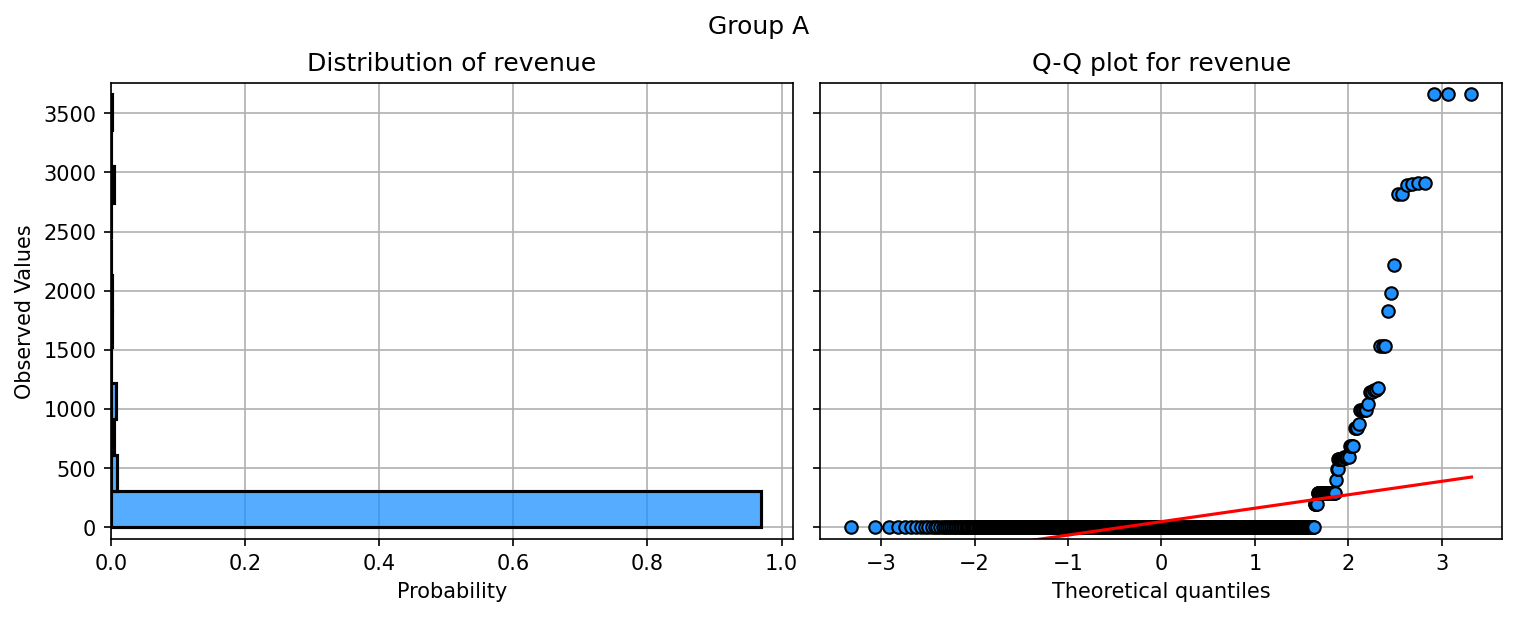

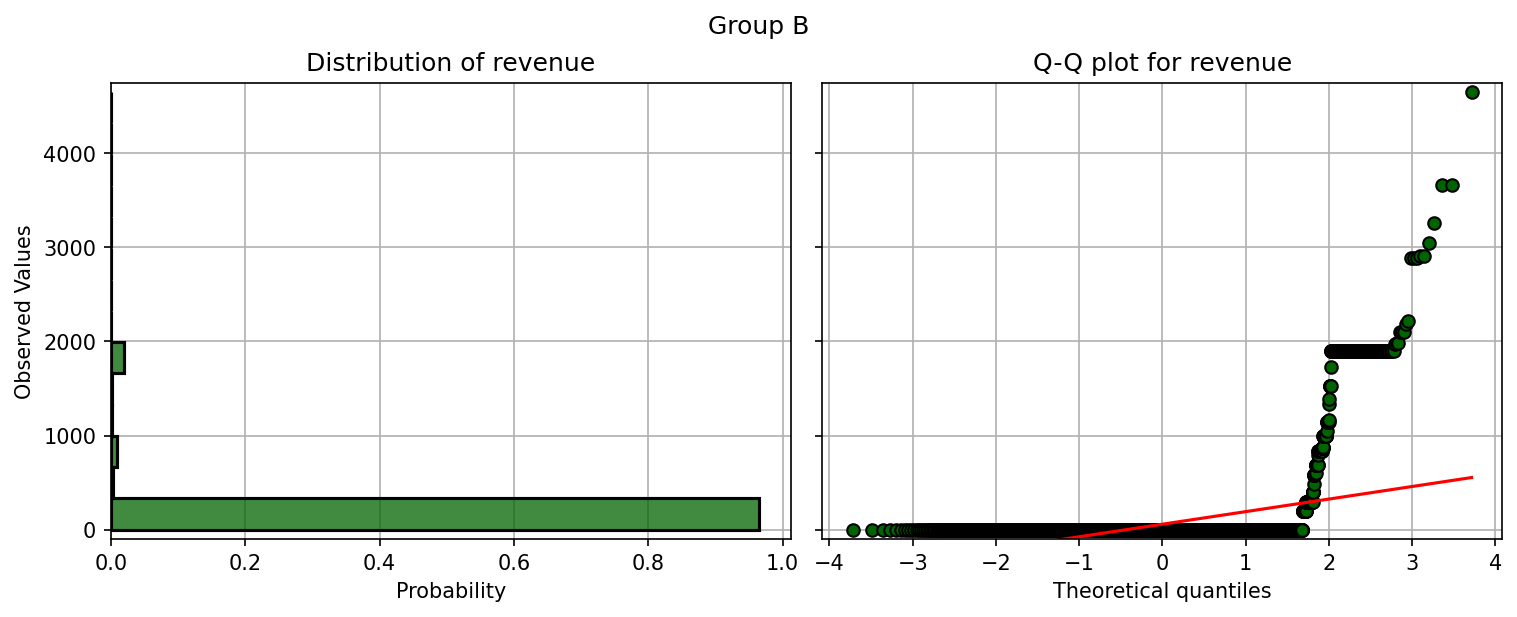

In [48]:
## Group A
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 4), constrained_layout=True,
                       sharey=True)
fig.suptitle('Group A')
#
sns.histplot(y=group_a['revenue'], stat='probability', color='dodgerblue',
             linewidth=1.5, ax=ax[0], zorder=3)
ax[0].set(title='Distribution of revenue', ylabel='Observed Values',
          ylim=[-100, group_a['revenue'].max() + 100])
ax[0].grid(zorder=-1)
#
probplot = stats.probplot(group_a['revenue'], plot=ax[1])
ax[1].get_lines()[0].set_markerfacecolor('dodgerblue')
ax[1].get_lines()[0].set_color('k')
ax[1].set(title='Q-Q plot for revenue', ylabel='')
ax[1].grid();

## Group B
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 4), constrained_layout=True,
                       sharey=True)
fig.suptitle('Group B')
#
sns.histplot(y=group_b['revenue'], stat='probability', color='darkgreen',
             linewidth=1.5, ax=ax[0], zorder=3)
ax[0].set(title='Distribution of revenue', ylabel='Observed Values',
          ylim=[-100, group_b['revenue'].max() + 100])
ax[0].grid(zorder=-1)
#
probplot = stats.probplot(group_b['revenue'], plot=ax[1])
ax[1].get_lines()[0].set_markerfacecolor('darkgreen')
ax[1].get_lines()[0].set_color('k')
ax[1].set(title='Q-Q plot for revenue', ylabel='')
ax[1].grid();

Хорошо видно, что данные из обеих групп не распределены нормально: подавляющая часть измерений сосредоточена в нуле (= большинство пользователей не тратили деньги). 

In [49]:
group_a['revenue'].value_counts().head()

revenue
0.0      1460
290.0      25
580.0       6
199.0       5
990.0       5
Name: count, dtype: int64

In [50]:
group_b['revenue'].value_counts().head()

revenue
0.0000       6489
1900.0000      93
290.0000       45
1900.0001      35
199.0000       27
Name: count, dtype: int64

В распределении *revenue* группы В обнаружено 93 повторения значения 1900 и 35 повторений значения 1900.0001. Столь малое различие между двумя значениями, а также большое число их повторений могут свидетельствовать об ошибке, сделанной на этапе сбора данных. Тем не менее, поскольку имеющаяся информация не позволяет однозначно определить природу этого кластера наблюдений, он не будет исключен из дальнейших построений.

Созданные визуализации свидетельствуют о том, что распределения выборок *revenue* обеих групп не являются нормальными. Тем не менее, подтвердим данное предположение при помощи статистических тестов Шапиро-Уилка и Харке-Бера. Эти тесты существенно различаются с точки зрения вычислений и математического устройства, однако, с некоторыми оговорками, они проверяют одинаковые гипотезы: 
* **нулевая гипотеза H<sub>0</sub>**: данные взяты из популяции, которая имеет нормальное распределение;
* **альтернативная гипотеза H<sub>1</sub>**: популяция, из которой были взяты данные, не подчиняется нормальному распределению.

Главное различие между этими тестами состоит в их области применения. Так, если размер проверяемого набора данных меньше 5000 наблюдений (как в группе А), тест Шапиро-Уилка даст более надежный результат. В случае, если набор данных превышает 5000 наблюдений, следует использовать тест Харке-Бера (группе В).

In [51]:
print(f"Group A:\n{pg.normality(group_a['revenue'], method='shapiro')}")
print(f"\nGroup B:\n{pg.normality(group_b['revenue'], method='jarque_bera')}")

Group A:
                W          pval  normal
revenue  0.154167  1.113974e-63   False

Group B:
                     W  pval  normal
revenue  547732.488043   0.0   False


Для обеих групп полученное в результате теста p-value меньше порогового значения 0.05, поэтому нулевая гипотеза отвергается в пользу альтернативной. В свою очередь, из принятия H<sub>1</sub> следует ненормальность распределения значений *revenue* выборок А и В. Таким образом, данные не удовлетворяют как минимум одной из трёх предпосылок, лежащих в основе t-теста.

Какие существуют альтернативные подходы оценки статистической значимости разницы между показателями **ARPU** групп А и В?
1. **Непараметрический тест Манна-Уитни.** Сравнивая кумулятивные функции двух независимых выборок, оценивает разницу между лежащими в их основе популяциями.
Однако, в отличие от t-теста, тест Манна-Уитни не делает выводов о средних значениях групп / популяций. Если с помощью теста Манна-Уитни была отвергнута нулевая гипотеза, это означает, что статистически значимо различаются именно распределения двух групп, что не обязательно связано с разницей в их средних значениях. Таким образом, тест Манна-Уитни не дает однозначного ответа на вопрос: «является ли различие метрик **ARPU** групп A и B статистически значимым?». Кроме того, при значительных различиях в размерах выборок, как в рассматриваемой ситуации, данный тест может быть смещён в сторону более крупной из них.
2. **Перестановочный тест для разницы средних значений выборок.** Оценивает вероятность того, что наблюдаемая разница между средними значениями является результатом случайной вариации, а не систематического различия между группами. Предъявляет минимум требований к тестируемым данным (независимость измерений, одинаковое распределение данных в пределах выборки).

Реализуем перестановочный тест для оценки стат. значимости различия между средними значения (=**ARPU**) групп А и В. Прежде всего, зададим функцию для расчета тестовой статистики - разности между средним значением группы В и средним значением группы А. Такой порядок членов обусловлен выполненным для наблюдённых данных предположением, что пользователи из В, взаимодействующие с новой механикой оплаты, тратят в среднем больше денег.

In [52]:
def statistic (a, b, axis):
    '''Функция для расчета тестовой статистики'''
    return np.mean(b, axis) - np.mean(a, axis)

Сформулируем гипотезы, исследуемые перестановочным тестом для разницы средних двух выборок:
* **нулевая гипотеза H<sub>0</sub>**: выборки А и В взяты из одной и той же популяции;
* **альтернативная гипотеза H<sub>1</sub>**: выборки А и В взяты из разных популяций, причем среднее значение популяции В больше, чем популяции А.

*p-value* будет рассчитано как процент значений из распределения нулевой гипотезы, которые больше или равны наблюдённой тестовой статистике.

In [53]:
perm_res = stats.permutation_test(
    (group_a['revenue'], group_b['revenue']),
    statistic, vectorized=True,
    n_resamples=9999, alternative='greater'
)
print(f'p-value is {perm_res.pvalue}')

p-value is 0.1105


Полученное p-value превышает пороговое значение 0.05, поэтому нулевая гипотеза не отклоняется. 

Визуализируем распределение нулевой гипотезы и наблюдённую тестовую статистику:

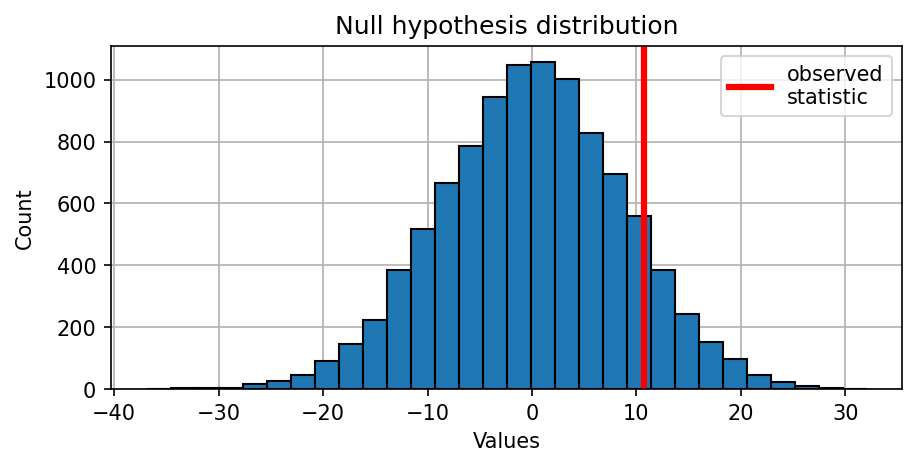

In [54]:
fig, ax = plt.subplots(dpi=150, figsize=(6, 3), constrained_layout=True)
ax.hist(perm_res.null_distribution, bins=30, edgecolor='black', zorder=2)
ax.axvline(x=delta, color='red', linewidth=3, label='observed\nstatistic')
ax.set(title='Null hypothesis distribution', xlabel='Values', ylabel='Count')
ax.grid(zorder=-1)
ax.legend();

Таким образом, результат перестановочного теста свидетельствует о том, что разница между показателями **ARPU** групп А и В не является статистически значимой. Иными словами, введение нового механизма оплаты не оказало существенного влияния на размер среднего чека, рассчитанного по всем активным пользователям.

### ARPPU
**ARPPU (average revenue per paying user)** - это отношение дохода, полученного со всех пользователей, к числу пользователей, совершивших хотя бы одну покупку. Поскольку данный показатель отличается от **ARPU** ~одной буквой~ только используемым при его расчете знаменателем, для оценки стат. значимости различия **ARPPU** групп А и В реализуем процедуру, аналогичную описанной в предыдущем разделе. Чтобы избежать лишних повторений, там, где это уместно, опустим развернутые комментарии с описанием производимых действий и их логики. 

Отфильтруем таблицу **upd_df** по значениям 'А' / 'В' колонки *group* и 1 колонки *made_purchase*, затем исключим из результата столбцы *group* и *made_purchase* и сохраним его в переменную **group_a** / **group_b**.

In [55]:
group_a = upd_df.query("group=='A' and made_purchase==1") \
    .drop(columns=['group', 'made_purchase'])
group_b = upd_df.query("group=='B' and made_purchase==1") \
    .drop(columns=['group', 'made_purchase'])

Чему равна дельта **ARРPU** групп?

In [56]:
arppu_a = group_a['revenue'].mean()
arppu_b = group_b['revenue'].mean()
delta = arppu_b - arppu_a  # мы ожидаем, что ARРPU группы В будет больше
print(f"ARPPU of A: {arppu_a}, ARPPU of B: {arppu_b}\nDifference: {delta}")

ARPPU of A: 933.5897435897435, ARPPU of B: 1257.8789920382164
Difference: 324.2892484484729


Уточним размер исследуемых групп.

In [57]:
print('Group\tSize')
print(f'A\t{group_a.shape[0]}\nB\t{group_b.shape[0]}')

Group	Size
A	78
B	314


Как и в случае **ARPU**, рассматриваемые выборки являются несбалансированными: количество пользователей в группах А и В соотносится как 1:4 (для **ARPU**- как 1:4.4). С другой стороны, размер выборок для расчета **ARРPU** существенно меньше размера выборок для расчета **ARPU**. Из этого следует, что при прочих равных условиях минимальный эффект, детектируемый статистическими тестами выборок **ARРPU**, будет больше, чем в случае тестов данных **ARPU**. 

Оценим соответствие распределения значений *revenue* групп А и В нормальному распределению:
* при помощи визуализаций;
* посредством статистических тестов.

Построим гистограммы и Q-Q графики для значений *revenue* групп A и B.

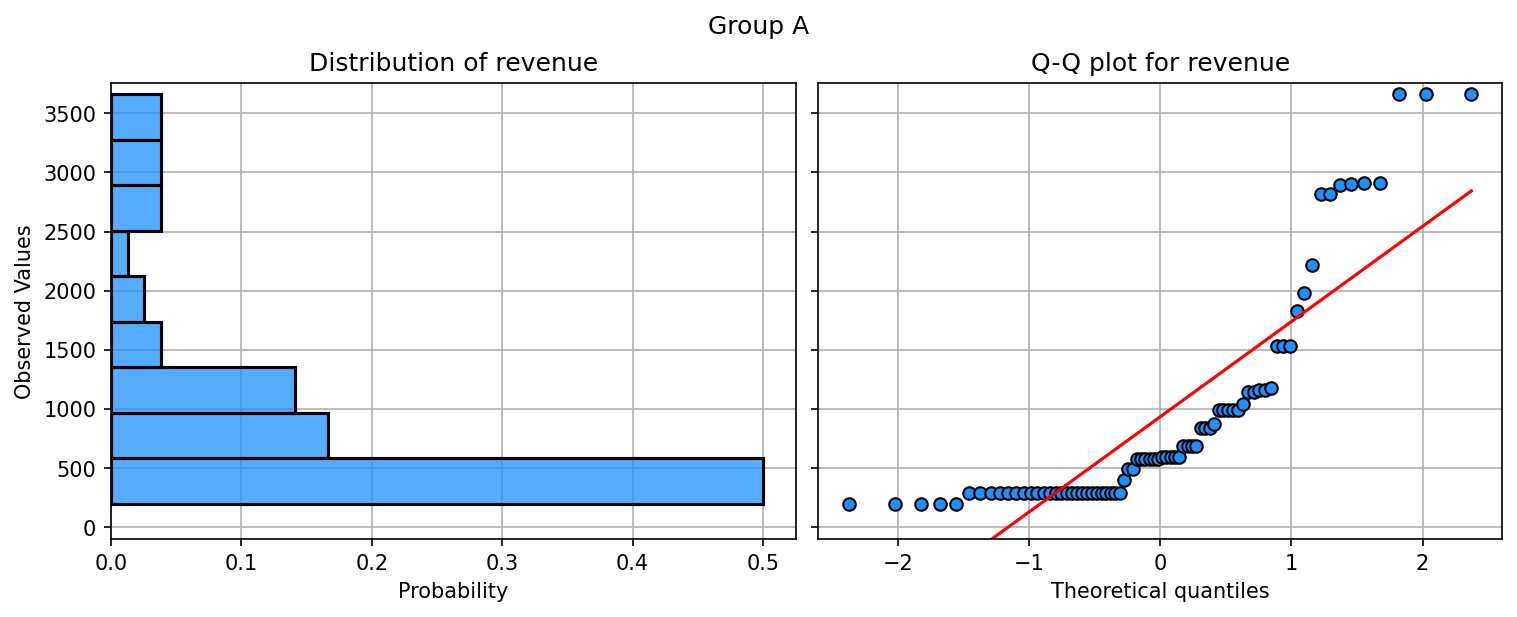

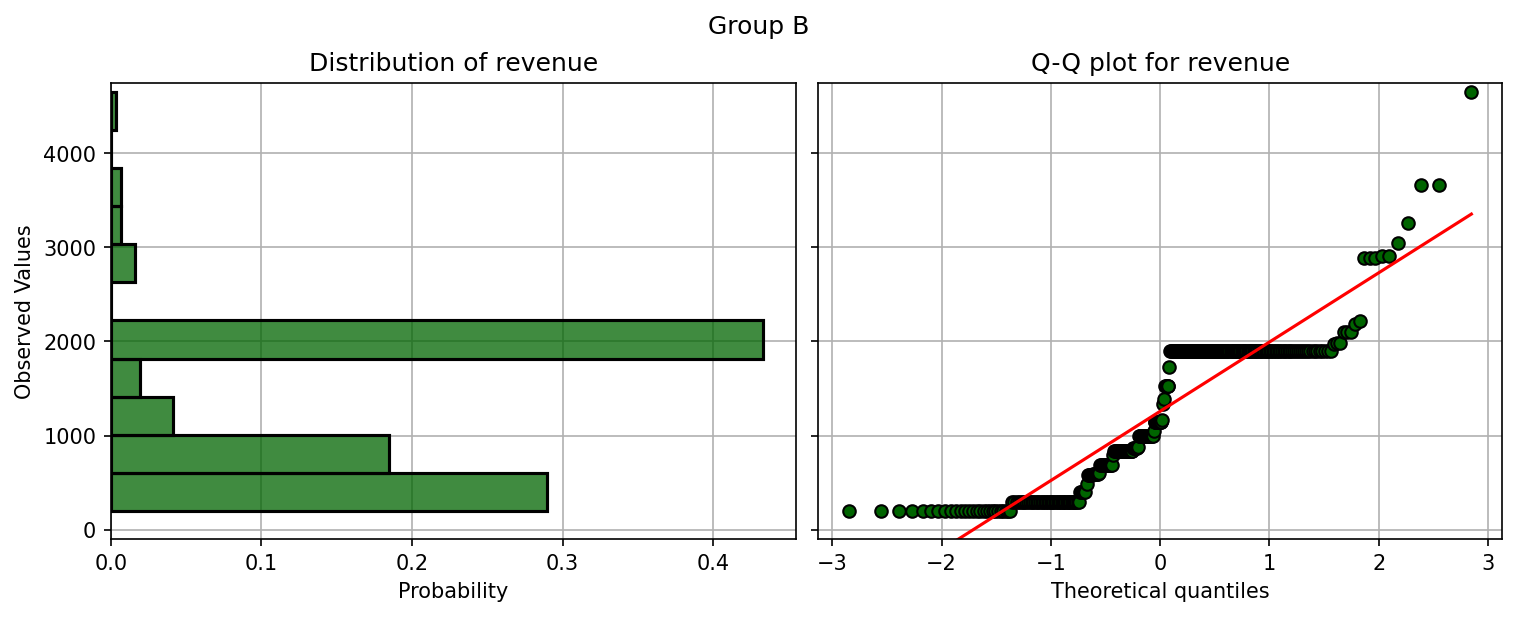

In [58]:
## Group A
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 4), constrained_layout=True,
                       sharey=True)
fig.suptitle('Group A')
#
sns.histplot(y=group_a['revenue'], stat='probability', color='dodgerblue',
             linewidth=1.5, ax=ax[0], zorder=3)
ax[0].set(title='Distribution of revenue', ylabel='Observed Values',
          ylim=[-100, group_a['revenue'].max() + 100])
ax[0].grid(zorder=-1)
#
probplot = stats.probplot(group_a['revenue'], plot=ax[1])
ax[1].get_lines()[0].set_markerfacecolor('dodgerblue')
ax[1].get_lines()[0].set_color('k')
ax[1].set(title='Q-Q plot for revenue', ylabel='')
ax[1].grid();

## Group B
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 4), constrained_layout=True,
                       sharey=True)
fig.suptitle('Group B')
#
sns.histplot(y=group_b['revenue'], stat='probability', color='darkgreen',
             linewidth=1.5, ax=ax[0], zorder=3)
ax[0].set(title='Distribution of revenue', ylabel='Observed Values',
          ylim=[-100, group_b['revenue'].max() + 100])
ax[0].grid(zorder=-1)
#
probplot = stats.probplot(group_b['revenue'], plot=ax[1])
ax[1].get_lines()[0].set_markerfacecolor('darkgreen')
ax[1].get_lines()[0].set_color('k')
ax[1].set(title='Q-Q plot for revenue', ylabel='')
ax[1].grid();

In [59]:
group_a['revenue'].value_counts().head()

revenue
290.0    25
580.0     6
990.0     5
199.0     5
590.0     5
Name: count, dtype: int64

In [60]:
group_b['revenue'].value_counts().head()

revenue
1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
Name: count, dtype: int64

Из визуализаций следует, что данные из обеих групп не распределены нормально. Распределение *revenue* группы А напоминает экспоненциальное с максимумом в диапазоне значений 250 – 500. Это кажется логичным: чем больше сумма, тем меньше число пользователей, действительно потративших её на услуги обучающей платформы. Однако в случае группы В эта логика нарушается: из-за уже упомянутых в предыдущем разделе значений 1900.0000 и 1900.0001 самый высокий столбец гистограммы не расположен ближе всех остальных к нулю оси наблюденных *revenue*. Тем не менее, ввиду отсутствия возможности исследовать природу этих данных, они не будут считаться следствием ошибки и исключаться из дальнейших построений.

Поскольку обе выборки состоят из относительно небольшого числа элементов, для вероятностной оценки нормальности их распределения выполним тесты Шапиро-Уилка.
* **нулевая гипотеза H<sub>0</sub>**: данные взяты из популяции, которая имеет нормальное распределение;
* **альтернативная гипотеза H<sub>1</sub>**: популяция, из которой были взяты данные, не подчиняется нормальному распределению.

In [61]:
print(f"Group A:\n{pg.normality(group_a['revenue'], method='shapiro')}")
print(f"\nGroup B:\n{pg.normality(group_b['revenue'], method='shapiro')}")

Group A:
                W          pval  normal
revenue  0.735324  1.498692e-10   False

Group B:
                W          pval  normal
revenue  0.854722  1.543336e-16   False


В обоих случаях полученное в p-value меньше порогового значения 0.05, и поэтому нулевая гипотеза отвергается в пользу альтернативной. Принятие H<sub>1</sub> указывает на ненормальность распределения значений *revenue* групп А и В, что, в свою очередь, говорит о некорректности применения t-теста для исследования разницы между средними этих выборок.

Как и в случае **ARPU**, для оценки статистической значимости различия между средними значения групп реализуем перестановочный тест. 
* **нулевая гипотеза H<sub>0</sub>**: выборки А и В взяты из одной и той же популяции;
* **альтернативная гипотеза H<sub>1</sub>**: выборки А и В взяты из разных популяций, причем среднее значение популяции В больше, чем популяции А.

*p-value* будет рассчитано как процент значений из распределения нулевой гипотезы, которые больше или равны наблюдённой тестовой статистике.

Зададим функцию для расчета тестовой статистики - разности между средним значением группы В и средним значением группы А.

In [62]:
def statistic (a, b, axis):
    '''Функция для расчета тестовой статистики'''
    return np.mean(b, axis) - np.mean(a, axis)

Выполним тест и выведем полученное p-value.

In [63]:
perm_res = stats.permutation_test(
    (group_a['revenue'], group_b['revenue']),
    statistic, vectorized=True,
    n_resamples=9999, alternative='greater'
)
print(f'p-value is {perm_res.pvalue}')

p-value is 0.001


p-value не превышает пороговое значение 0.05, поэтому нулевая гипотеза отклоняется в пользу альтернативной. 

Визуализируем распределение нулевой гипотезы и наблюдённую тестовую статистику:

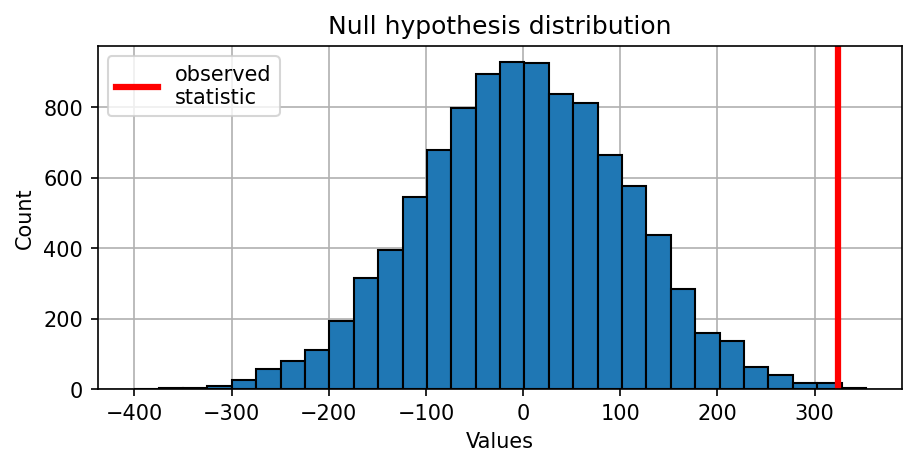

In [64]:
fig, ax = plt.subplots(dpi=150, figsize=(6, 3), constrained_layout=True)
ax.hist(perm_res.null_distribution, bins=30, edgecolor='black', zorder=2)
ax.axvline(x=delta, color='red', linewidth=3, label='observed\nstatistic')
ax.set(title='Null hypothesis distribution', xlabel='Values', ylabel='Count')
ax.grid(zorder=-1)
ax.legend();

Согласно результатам перестановочного теста, **ARPPU** группы В статистически значимо превышает этот же показатель группы А. Это свидетельствует о том, что введение нового механизмы оплаты позволило существенно увеличить средний чек платящих пользователей.

Однако при принятии окончательного решения о развертывании новой механики оплаты на всех пользователей следует учесть, что данный тест проводился на базе относительно небольших выборок, которые отличались по размеру в 4 раза: 78 элементов в группе А и 314 элементов в группе В. Помимо этого дисбаланса, нужно иметь в виду, что 128 наблюдений из группы В, соответствующих значениям 1900.0000 и 1900.0001, могут быть скомпрометированы.   

## Выводы

In [65]:
upd_df_summary.round(3)

,users_total,users_purchase,revenue_total
group,,,
A,1538,78,72820.000
B,6803,314,394974.004


In [66]:
upd_df_metrics.loc['Delta'] = upd_df_metrics.loc['B'] - upd_df_metrics.loc['A']
upd_df_metrics.round(3)

,CR,ARPU,ARPPU
group,,,
A,5.072,47.347,933.590
B,4.616,58.059,1257.879
Delta,-0.456,10.712,324.289


Для изучения влияния нового дизайна системы оплаты на сайте было произведено сравнение данных двух групп пользователей: участникам группы А выводился старый дизайн, а группы В - новый. Данные сравнивались по трем показателям, но в качестве основного была выбрана **конверсия (CR)**, а **ARPU** и **ARPPU** носили справочный характер.
* Несмотря на то, что **CR** группы В на 0.456 меньше, чем **CR** группы А, из результатов применения критерия хи-квадрат следует, что эта разница не является статистически значимой.
* Дельта метрик **ARPU** (10.712) и **ARPPU** (324.289) групп А и В была проверена на статистическую значимость при помощи перестановочных тестов. Согласно их результатам, различие между **ARPU** групп не является стат. значимым, тогда как различие между **ARPPU** - является. Однако следует учитывать, что тест для **ARPPU** проводился на относительно небольших выборках, которые также отличались по размеру в 4 раза: 78 элементов в группе А и 314 элементов в группе В. Помимо этого, значительное количество наблюдений из группы В, а именно 128, могли быть записаны некорректно. Если это действительно так, эти значения смещают среднее выборки и тем самым существенно влияют на аутпут перестановочного теста.

Таким образом, из трех рассмотренных пар метрик статистически значимое различие выявлено лишь для справочной **ARPPU**, причем надежность этого результата поставлена под сомнение. Поэтому я **не рекомендую** немедленную замену старой механики оплаты услуг на новую. Вместо этого я предлагаю провести новое А/В-тестирование, в рамках которого:
* группы будут иметь сопоставимый размер;
* накопление данных будет осуществляться в течение более длительного времени;
* сведения о пользователях, совершивших платеж в период накопления данных, но не посещавших на платформу, не будут сохраняться;
* больше внимания будет уделено проверке достоверности регистрируемых данных.